# SpatialDE

SpatialDE is a method to identify genes which signfificantly depend on spatial coordinates in non-linear and non-parametric ways. The intended applications are spatially resolved RNA-sequencing from e.g. Spatial Transcriptomics, or _in situ_ gene expression measurements from e.g. SeqFISH or MERFISH.

This repository contains both the implementations of our method, as well as case studies in applying it.

The key features of our method are

  - Unsupervised - No need to define spatial regions
  - Non-parametric and non-linear expression patterns
  - Extremely fast - Transcriptome wide tests takes only a few minutes on normal computers
  
The primary implementation is as a Python3 package, and can be installed from the command line by 

```
$ pip install spatialde
```

To see usage example of SpatialDE either keep reading, or look in the `Analysis` directory. Here is brief description of the examples provided:

  - `BreastCancer` - Transcriptome wide study on breast cancer tissue from Spatial Transcriptomics.
  - `Frog` - A time course of RNA-seq ("1-d space") of _Xenopus_ development.
  - `MERFISH` - Expression from single cells in a region of an osteoblast culture using the MERFISH technology with 140 probes.
  - `MouseOB` - Spatial Transcriptomics assay of a slice of Mouse Olfactory Bulb. (Also see below).
  - `SeqFISH` - Expression counts of single cells from mouse hippocampus using the SeqFISH technology with 249 probes.

Below follows a typical usage example in interactive form.

In [1]:
%pylab inline
import pandas as pd

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

import NaiveDE
import SpatialDE

Populating the interactive namespace from numpy and matplotlib


As an example, let us look at spatially dependent gene expression in Mouse Olfactory Bulb using a data set published in Stahl et al 2016. With the authors method, hundrads of locations on a tissue slice can be sampled at once, and gene expression is measured by sequencing in an unbiased while-transcriptome manner.

In [2]:
counts = pd.read_csv('Analysis/MouseOB/data/Rep11_MOB_0.csv', index_col=0)
counts = counts.T[counts.sum(0) >= 3].T  # Filter practically unobserved genes

print(counts.shape)
counts.iloc[:5, :5]

(262, 14859)


,Nrf1,Zbtb5,Ccnl1,Lrrfip1,Bbs1
16.92x9.015,1,1,1,2,1
16.945x11.075,0,0,3,2,2
16.97x10.118,0,1,1,0,0
16.939x12.132,1,0,1,0,4
16.949x13.055,0,0,0,3,0


In [3]:
sample_info = pd.read_csv('Analysis/MouseOB/MOB_sample_info.csv', index_col=0)
counts = counts.loc[sample_info.index]  # Align count matrix with metadata table

sample_info.head(5)

,x,y,total_counts
16.92x9.015,16.920,9.015,18790
16.945x11.075,16.945,11.075,36990
16.97x10.118,16.970,10.118,12471
16.939x12.132,16.939,12.132,22703
16.949x13.055,16.949,13.055,18641


We can plot the x and y coordinates in the sample info table to see which locations of the tissue slice has been sampled.

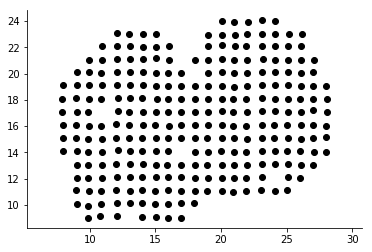

In [4]:
figsize(6, 4)
plt.scatter(sample_info['x'], sample_info['y'], c='k');
plt.axis('equal');

Our method assumes normally distributed noise, but the data we are using is from expression counts, and empirically seems to follow a negative binomial distribution. We use technique by Anscombe to approximately transform the data to normal distributed noise.

Secondly, library size or sequencing depth of the spatial samples will bias the expression of every gene. We use linear regression to account for this effect before performing the spatial test.

In [5]:
norm_expr = NaiveDE.stabilize(counts.T).T
resid_expr = NaiveDE.regress_out(sample_info, norm_expr.T, 'np.log(total_counts)').T

For the sake of this example, let's just run the test on 1000 random genes. This should just take a few seconds. With our very fast implementation, testing all 14,000 genes takes about 10 minutes.

In [6]:
sample_resid_expr = resid_expr.sample(n=1000, axis=1, random_state=1)

X = sample_info[['x', 'y']]
results = SpatialDE.run(X, sample_resid_expr)

INFO:root:Performing DE test
INFO:root:Pre-calculating USU^T = K's ...
INFO:root:Done: 0.1s
INFO:root:Fitting gene models
INFO:root:Model 1 of 10
INFO:root:Model 2 of 10                             
INFO:root:Model 3 of 10                            
INFO:root:Model 4 of 10                             
INFO:root:Model 5 of 10                            
INFO:root:Model 6 of 10                             
INFO:root:Model 7 of 10                             
INFO:root:Model 8 of 10                            
INFO:root:Model 9 of 10                             
INFO:root:Model 10 of 10                            


The result will be a DataFrame with P-values and other relevant values for each gene.

The most important columns are

  - `g` - The name of the gene
  - `pval` - The P-value for spatial differential expression
  - `qval` - Signifance after correcting for multiple testing
  - `l` - A parameter indicating the distance scale a gene changes expression over

In [7]:
results.head().T

,0,1,2,3,4
Gower,0.999295,0.999295,0.999295,0.999295,0.999295
M,4,4,4,4,4
g,2410016O06Rik,Angel2,Hes6,Fam84a,Aldh3a2
l,0.402001,0.402001,0.402001,0.402001,0.402001
max_delta,0.0295523,0.03714,0.21691,0.0352182,0.98549
max_ll,-52.2817,-113.227,23.093,-122.552,-73.012
max_mu_hat,-0.826809,-1.20788,0.140246,-4.60602,-1.72603
max_s2_t_hat,0.650257,1.33346,0.0544851,17.5935,1.4265
model,SE,SE,SE,SE,SE
n,260,260,260,260,260


In [8]:
results.sort_values('qval').head(10)[['g', 'l', 'qval']]

,g,l,qval
892,Kcnh3,1.907609,0.001512
739,Pcp4,1.135190,0.013843
517,Igfbp2,1.135190,0.013843
800,Gng13,1.907609,0.022632
262,Naaa,0.675535,0.051705
827,Gng4,1.907609,0.051705
587,Map1b,1.135190,0.051705
459,Fmo1,1.135190,0.096710
356,Slc38a3,1.135190,0.096710
344,Hpcal4,1.135190,0.107360


We detected a few spatially differentially expressed genes, _Cck_ and _Ptn_ for example.

A simple way to visualize these genes is by plotting the x and y coordinates as above, but letting the color correspond to expression level.

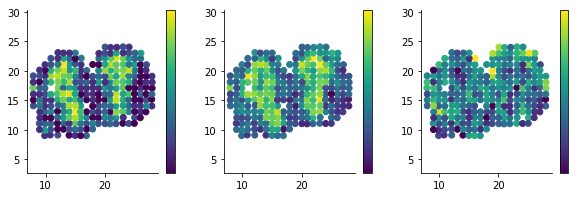

In [9]:
figsize(10, 3)
for i, g in enumerate(['Kcnh3', 'Pcp4', 'Igfbp2']):
    plt.subplot(1, 3, i + 1)
    plt.scatter(sample_info['x'], sample_info['y'], c=norm_expr[g]);
    plt.axis('equal')

    
    plt.colorbar(ticks=[]);

For reference, we can compare these to genes which are not spatially DE

In [10]:
results.sort_values('qval').tail(10)[['g', 'l', 'qval']]

,g,l,qval
338,Myo9b,1.135190,0.980077
336,Sc4mol,1.135190,0.980077
335,Phf11b,1.135190,0.980077
334,Cytip,1.135190,0.980077
333,Bbs12,1.135190,0.980077
337,Dnase2a,1.135190,0.980077
525,Foxc1,1.135190,0.980448
659,BC068281,1.135190,0.981408
880,Olfr1204,1.907609,1.000000
638,Rspo1,1.135190,1.000000


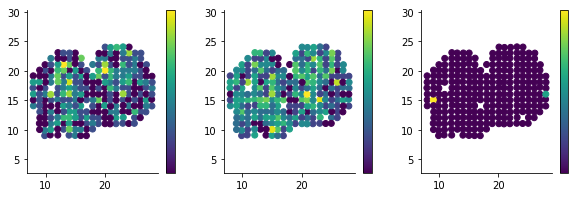

In [11]:
figsize(10, 3)
for i, g in enumerate(['Myo9b', 'Sc4mol', 'Phf11b']):
    plt.subplot(1, 3, i + 1)
    plt.scatter(sample_info['x'], sample_info['y'], c=norm_expr[g]);
    plt.axis('equal')

    
    plt.colorbar(ticks=[]);

In regular differential expression analysis, we usually investigate the relation between significance and effect size by so called _volcano plots_. We don't have the concept of fold change in our case, but we can investigate the fraction of variance explained by spatial variation.

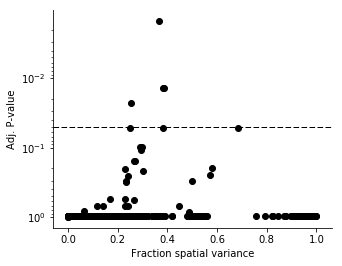

In [12]:
figsize(5, 4)
plt.yscale('log')

plt.scatter(results['fraction_spatial_variance'], results['qval'], c='black')

plt.axhline(0.05, c='black', lw=1, ls='--');

plt.gca().invert_yaxis();
plt.xlabel('Fraction spatial variance')
plt.ylabel('Adj. P-value');